In [13]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path = '../helperScripts/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
n_cells_per_cluster = 25
clone_scores = pd.read_csv(f'../extractedData/in_vivo/clone_scores_{n_cells_per_cluster}cellspercluster.csv',index_col=0)
# clone_scores = pd.read_csv('../extractedData/in_vivo/clone_scores.csv',index_col=0)
clone_scores['p_val_adj'] = clone_scores['p_val']*len(clone_scores.index)

n_rings =  25
# space_scores = pd.read_csv(f'../extractedData/space_scores_{n_rings}rings.csv',index_col=0)
space_scores = pd.read_csv(f'../extractedData/in_vivo/space_scores_{n_rings}rings_barcoded.csv',index_col=0)
space_scores['p_val_adj'] = space_scores['p_val']*len(space_scores.index)


In [15]:
space_scores

,score,p_val,p_val_adj
gene,,,
AKT1,5.029434,0.000083,0.009916
AXL,1.580550,0.058662,6.980752
BGN,1.558953,0.027414,3.262311
BIRC3,1.924990,0.007249,0.862678
BIRC5,5.218944,0.000083,0.009916
...,...,...,...
VGF,1.087301,0.300725,35.786268
WNT5A,1.205058,0.178652,21.259562
YAP1,3.218884,0.000083,0.009916


Number of genes with p-value less than 0.01 and score above 2: 34 total: 119


Text(0, 0.5, 'Ratio of real to permuted delta')

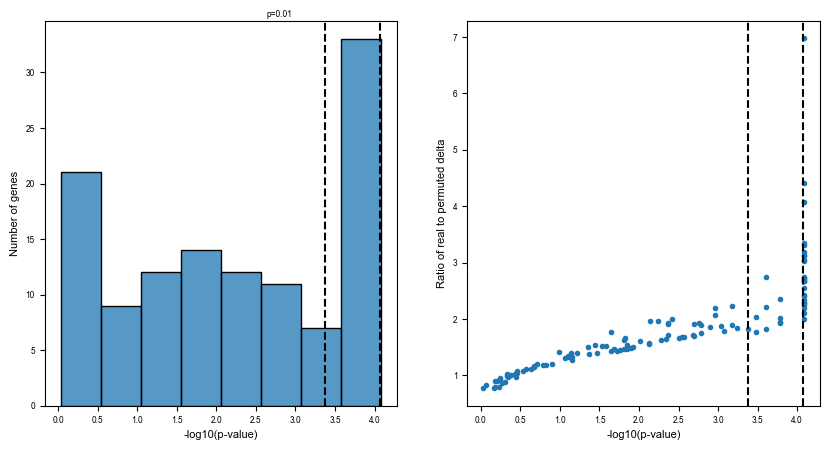

In [16]:
# plot clone scores and p-values]

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(clone_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((clone_scores['p_val'] < 0.01) & (clone_scores['score'] > 2)),'total:',len(clone_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(clone_scores['p_val']),clone_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(clone_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(clone_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

Number of genes with p-value less than 0.01 and score above 2: 63 total: 119


Text(0, 0.5, 'Ratio of real to permuted delta')

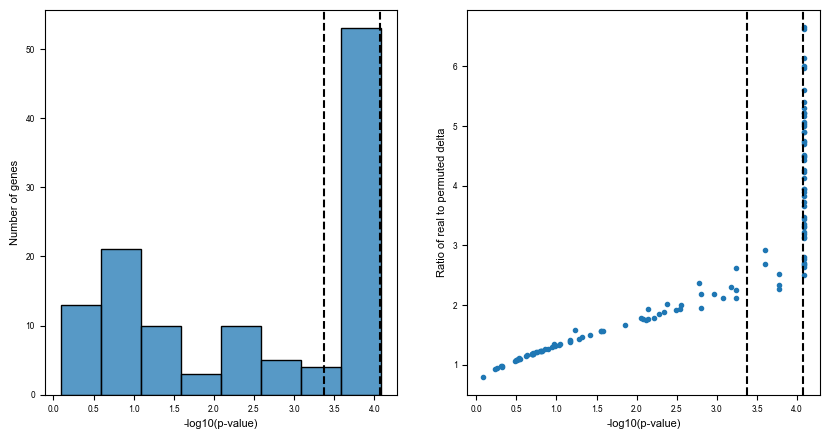

In [17]:
# plot space scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(space_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((space_scores['p_val'] < 0.01) & (space_scores['score'] > 2)),'total:',len(space_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(space_scores['p_val']),space_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(space_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(space_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

In [18]:
space_scores[space_scores['p_val_adj'] < 0.01]

,score,p_val,p_val_adj
gene,,,
AKT1,5.029434,0.000083,0.009916
BIRC5,5.218944,0.000083,0.009916
CALD1,4.266939,0.000083,0.009916
CAPG,4.692417,0.000083,0.009916
CCNA2,3.723899,0.000083,0.009916
CCND1,4.433614,0.000083,0.009916
CDK1,3.896343,0.000083,0.009916
CDKN1B,4.128271,0.000083,0.009916
COL1A1,4.725572,0.000083,0.009916


In [19]:
both_scores = pd.merge(clone_scores,space_scores,left_index=True,right_index=True,suffixes=('_clone','_space'))

In [20]:
both_scores[both_scores['p_val_adj_clone'] < 0.01]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
AKT1,2.341328,0.000083,0.009916,5.029434,0.000083,0.009916
CALD1,2.680858,0.000083,0.009916,4.266939,0.000083,0.009916
CAPG,2.244842,0.000083,0.009916,4.692417,0.000083,0.009916
CTNNB1,3.188066,0.000083,0.009916,5.213280,0.000083,0.009916
ESPN,2.201684,0.000083,0.009916,6.009059,0.000083,0.009916
FGFR1,4.067625,0.000083,0.009916,1.098042,0.294725,35.072327
FN1,3.312361,0.000083,0.009916,3.361628,0.000083,0.009916
GFP,2.416242,0.000083,0.009916,2.266246,0.000167,0.019832
HIF1A,2.290737,0.000083,0.009916,4.901085,0.000083,0.009916


In [21]:
both_scores[both_scores['p_val_adj_space'] < 0.01].count()

score_clone        48
p_val_clone        48
p_val_adj_clone    48
score_space        48
p_val_space        48
p_val_adj_space    48
dtype: int64

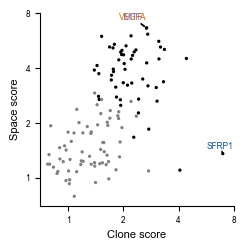

In [22]:
# plot ratio for clone and rings, only plotting genes present in both sets
# common_genes = [gene for gene in scores_ring.index if gene in scores.index]
plt.figure(figsize=(2.5,2.5))

color_list = []

score_cutoff = 2 
p_val_adj_cutoff = 0.01

# color points by p-value and score
for entry in both_scores.index:
    if both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['score_space'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff and both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff:
        color_list.append('k')
    elif both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff:
        color_list.append('k')
    elif both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff and both_scores['score_space'].loc[entry] > score_cutoff:
        color_list.append('k')
    else:
        color_list.append('gray')



plt.scatter(both_scores['score_clone'],both_scores['score_space'],marker='.',color=color_list,s=7.5)

plt.xlabel('Clone score\n(ratio of true difference to avg. permuted difference)')
plt.ylabel('Space score\n(ratio of true difference to avg. permuted difference)')

plt.xlabel('Clone score')
plt.ylabel('Space score')

# annotate top 5 genes for each using adjust_text

# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','ITGA8','MMP11']
# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','MMP1','BMP2']
genes_to_plot = ['VEGFA','SFRP1','MITF',
                #  'SPARC'
                 ]
gene_colors = ['b','orange','r','k']

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02', # dark orange
               'SFRP1':'#08519c', # blue
            #    'SPARC':'k',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3', # purple
               
               }


texts = []



for gene in genes_to_plot:
    texts.append(plt.text(both_scores['score_clone'].loc[gene],both_scores['score_space'].loc[gene],gene,ha='right',c=gene_colors[gene]))


plt.yscale('log',base=2)
plt.xscale('log',base=2)

plt.xticks([0.5,1,2,4,8],[0.5,1,2,4,8])
plt.yticks([0.5,1,2,4,8],[0.5,1,2,4,8])

plt.xlim(0.7,8)
plt.ylim(0.7,8)

sns.despine()



adjust_text(texts,x=both_scores['score_clone'],y=both_scores['score_space'],force_static=(2,2),arrowprops=dict(arrowstyle='-',color='k'))

plt.savefig('../graphs/clone_v_space_scores.pdf',bbox_inches='tight',transparent=True)
